# Spectral Biclustering

Ref: Kluger, Yuval, et. al., 2003. Spectral biclustering of microarray data: coclustering genes and conditions.
* [blog](http://www.kemaleren.com/post/spectral-biclustering-part-1/)

In [1]:
import numpy as np
import pandas as pd
import altair as alt

import concensus_clustering

from copy import deepcopy

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
feature_categories = [
    'shape',
    'firstorder',
    'glcm',
    'glrlm',
    'glszm',
    'gldm',
    'ngtdm',
    'PETparam', 
    'clinical'
]

In [3]:
def category_counts(_):
    
    return {
        'shape': 0,
        'firstorder': 0,
        'glcm': 0,
        'glrlm': 0,
        'glszm': 0,
        'gldm': 0,
        'ngtdm': 0,
        'PETparam': 0,
        'clinical': 0,
    }

In [4]:
def _update_count(pet_output, ct_output, key):

    if 'PET' in key:
        pet_output[key] += 1
    else:
        ct_output[key] += 1
            
    return pet_output, ct_output

In [5]:
def _norm_count(pet_output, ct_output, key, tot_counts):
    
    if 'PET' in key:
        pet_output[key] /= tot_counts[key]
    else:
        ct_output[key] /= tot_counts[key]
            
    return pet_output, ct_output

In [6]:
def to_feature_categories(cluster_indices, X):
    
    pet_output = category_counts(None)
    ct_output = category_counts(None)
    
    
    for label in X.columns[cluster_indices]:
        if 'shape' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'shape')
        elif 'firstorder' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'firstorder')
        elif 'glcm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glcm')
        elif 'glrlm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glrlm')
        elif 'glszm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glszm')
        elif 'gldm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'gldm')
        elif 'ngtdm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'ngtdm')
        elif 'PETparam' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'PETparam')
        else:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'clinical')
        
    feature_counts = {
        'shape': 13,
        'firstorder': 54,
        'glcm': 69,
        'glrlm': 48,
        'glszm': 48,
        'gldm': 42,
        'ngtdm': 15,
        'PETparam': 3, 
        'clinical': 42
    }
    for label in feature_counts.keys():
        pet_output, ct_output = _norm_count(pet_output, ct_output, label, feature_counts)

    return pet_output, ct_output

In [7]:
def biclusters(model, X, param_config):
    # Create Bicluster instances tracking detected clusters.
    
    # Start fresh with each clustering.
    _model = deepcopy(model)
    
    # Set number of clusters to detect and fit model to data.
    _model.set_params(**param_config)
    _model.fit(X)

    rows, cols = _model.rows_, _model.columns_
    # Sanity check.
    assert np.shape(rows)[0] == np.shape(cols)[0]
    
    biclusters = concensus_clustering.Biclusters(
        rows=rows, cols=cols, data=X
    )
    return biclusters

In [8]:
def checker_coords(model, num_clusters):
    # Collect coordinates for biclusters with a checkerborad structure.
    
    tot_num_clusters = num_clusters[0] * num_clusters[1]
    coords = pd.DataFrame(
        np.zeros((tot_num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    num, prev_rows = 0, 0
    for row_num in range(num_clusters[0]):
        nrows = np.sum(model.rows_[row_num])

        prev_cols = 0
        for col_num in range(num_clusters[1]):
            ncols = np.sum(model.columns_[col_num])

            coords.iloc[num, 0] = prev_rows 
            coords.iloc[num, 1] = prev_rows + nrows
            coords.iloc[num, 2] = prev_cols 
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows

    return coords

In [9]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        if 'shape' in label:
            prep_labels.append('Shape')
        elif 'PETparam' in label:
            prep_labels.append('PET Parameter')
        elif 'clinical' in label:
            prep_labels.append('Clinical')
        elif 'firstorder' in label:
            prep_labels.append('First Order')
        elif 'glcm' in label:
            prep_labels.append('GLCM')
        elif 'gldm' in label:
            prep_labels.append('GLDM')
        elif 'glrlm' in label:
            prep_labels.append('GLRLM')
        elif 'glszm' in label:
            prep_labels.append('GLSZM')
        elif 'ngtdm' in label:
            prep_labels.append('NGTDM')
        else:
            raise ValueError(f'Unknown label {label}')
    return prep_labels

In [10]:
SEED = 0 

In [11]:
np.random.seed(SEED)
bic_grid = ParameterGrid(
    {
        'n_clusters': [np.random.choice(np.arange(2, 10), size=2) for _ in range(10)],
        'method': ['scale', 'bistochastic'],
        'n_components': np.linspace(3, 20, 5, dtype=int)
    }
)

# Original Data 

In [12]:
_y = pd.read_csv('./../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0)
y_orig = np.squeeze(_y.values)

X_orig = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv', index_col=0)

scaler = StandardScaler()
X_orig_std = scaler.fit_transform(X_orig.values)
X_orig_std.shape

(198, 513)

In [13]:
orig_bic_scores = {}
for num, bic_param_config in enumerate(bic_grid):
    orig_bic_model = SpectralBiclustering(random_state=SEED, svd_method='arpack')
    orig_bic_clusters = biclusters(orig_bic_model, X_orig_std, bic_param_config)
    orig_bic_scores[num] = orig_bic_clusters.external_metrics

In [14]:
# Determine best biclustering config. (number of clusters).
avg_orig_bic_scores = []
for scores in orig_bic_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_orig_bic_scores.append(score)
    
best_orig_config = bic_grid[np.argmin(avg_orig_bic_scores)]
best_orig_config, min(avg_orig_bic_scores)

({'n_components': 15, 'n_clusters': array([6, 9]), 'method': 'bistochastic'},
 1.0070841668434274)

## Bicluster Map

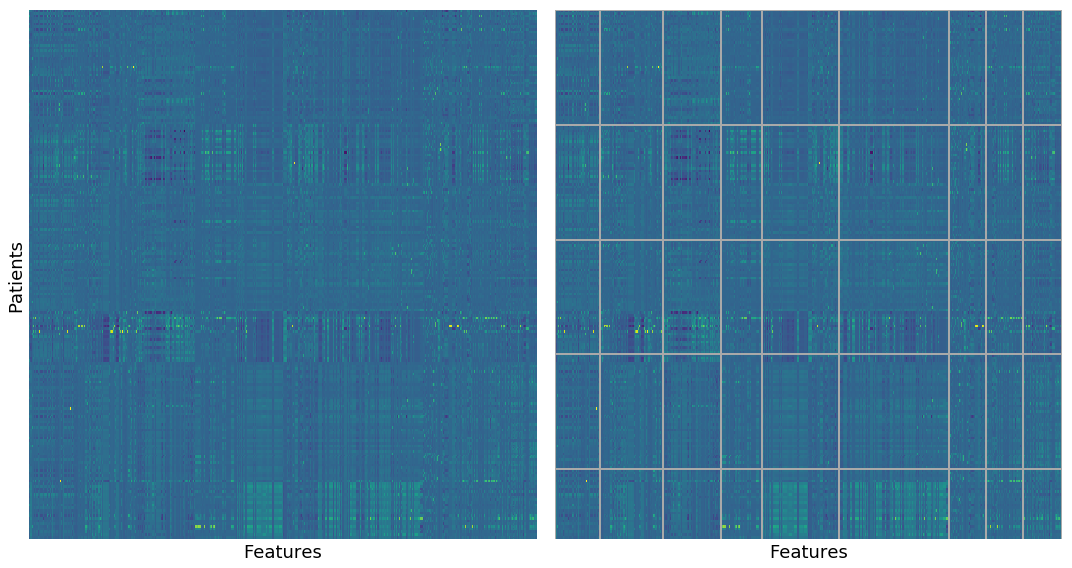

In [15]:
# Train model with best config.
orig_bic_model = SpectralBiclustering(random_state=SEED, svd_method='arpack')
orig_bic_model.set_params(**best_orig_config)
orig_bic_model.fit(X_orig_std)
orig_bic_row_sorted = X_orig_std[np.argsort(orig_bic_model.row_labels_), :]
orig_bic_fit_data = orig_bic_row_sorted[:, np.argsort(orig_bic_model.column_labels_)]


fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 8),
    sharey=True
)
sns.heatmap(
    orig_bic_fit_data, 
    ax=axes[0], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(orig_bic_fit_data), 
    vmax=np.max(orig_bic_fit_data),
    cbar=False
)
sns.heatmap(
    orig_bic_fit_data, 
    ax=axes[1], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(orig_bic_fit_data), 
    vmax=np.max(orig_bic_fit_data),
    cbar=False
)
coords = checker_coords(orig_bic_model, best_orig_config['n_clusters'])
for num in coords.index:
    axes[1].plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='darkgray'#'orangered' #darkred
)
axes[0].set_ylabel('Patients', fontsize=18)
for axis in axes.ravel():
    axis.set_xlabel('Features', fontsize=18)
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.tight_layout()

plt.savefig(
    './bicmap_original_images.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [16]:
# Collect row cluster info.
orig_row_idx = []
orig_pfs_outcome, orig_not_pfs_outcome = [], []
for bic_row_idx in np.unique(orig_bic_model.row_labels_):
    # Store cluster index and ID samples belonging to current cluster.
    orig_row_idx.append(bic_row_idx)
    row_cluster_samples = np.where(orig_bic_model.row_labels_ == bic_row_idx)

    # Store fractions of each outcome for current cluster.
    orig_pfs_outcome.append(sum(y_orig[row_cluster_samples] == 0) / np.size(y_orig))
    orig_not_pfs_outcome.append(sum(y_orig[row_cluster_samples] == 1) / np.size(y_orig))
    
orig_sorted_cluster_idx = np.concatenate((orig_row_idx, orig_row_idx))
orig_comb_results = np.concatenate((orig_pfs_outcome, orig_not_pfs_outcome))

orig_results_id =  np.concatenate((
    ['Progression-free Survival'] * len(orig_pfs_outcome), ['Other Event'] * len(orig_not_pfs_outcome)
))
df_orig_row_clusters = pd.DataFrame(
    {'comb_results': orig_comb_results, 'results_id': orig_results_id},
    index=orig_sorted_cluster_idx,
)

# Collect column cluster info.
orig_column_clusters = {}
for bic_col_idx in np.unique(orig_bic_model.column_labels_):    
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(orig_bic_model.column_labels_ == bic_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples, X_orig)
    orig_column_clusters[bic_col_idx] = {key: val_a + val_b for (key, val_a), (_, val_b) 
                                       in zip(pet_output.items(), ct_output.items())}
    
df_orig_column_clusters = pd.DataFrame(orig_column_clusters).T

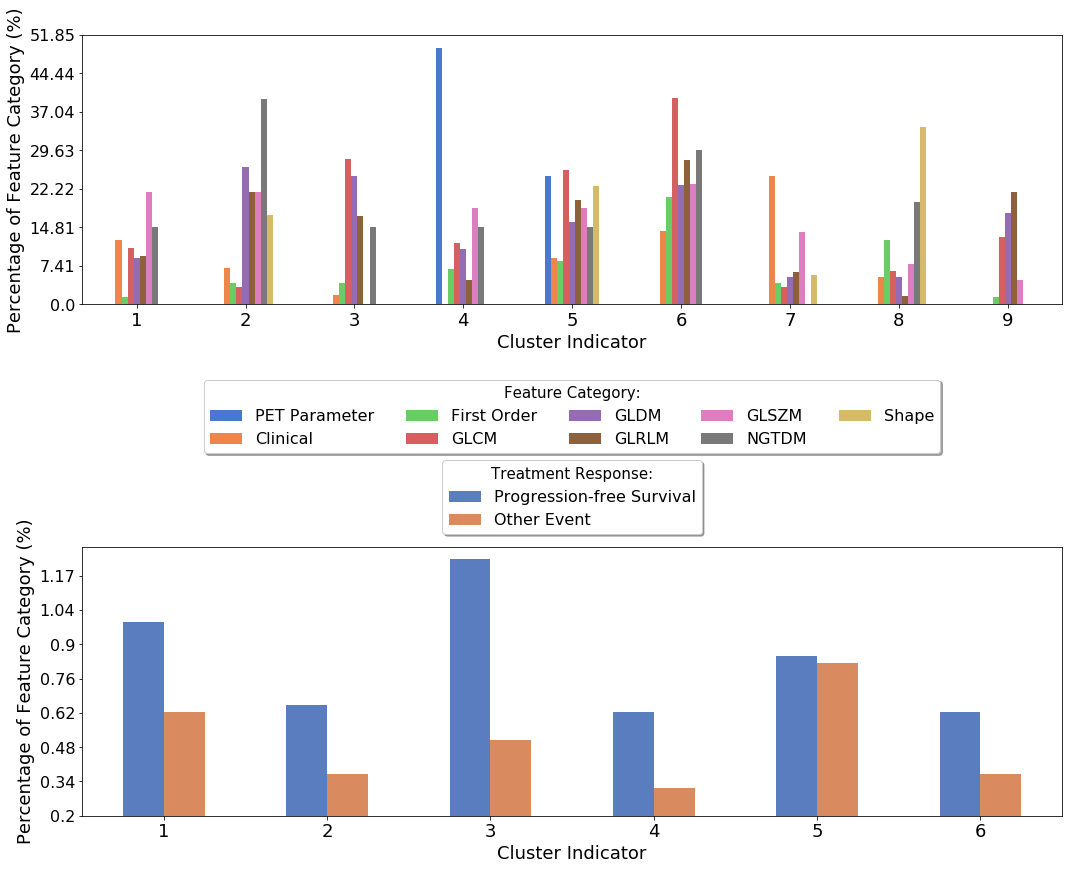

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 12))
df_orig_column_clusters.plot(
    kind='bar', 
    ax=axes[0], 
    colormap=ListedColormap(sns.color_palette('muted', n_colors=9))
)
sns.barplot(
    x=orig_sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_orig_row_clusters,
    palette='muted',
    ax=axes[1]
)
for num, patch in enumerate(axes[1].patches):
    if num in np.arange(len(axes[1].patches) * 0.5, dtype=int):
        patch.set_width(0.25)
        patch.set_x(patch.get_x() + 0.15)
    else:
        patch.set_width(0.25)

axes[0].set_xticklabels(np.arange(20) + 1, fontsize=18, rotation=0)
axes[1].set_xticklabels(np.arange(20) + 1, fontsize=18, rotation=0)

axes[0].set_yticklabels(
    np.round(np.linspace(
        np.min(df_orig_column_clusters.values) * 100, 
        np.max(df_orig_column_clusters.values) * 100, 
        len(df_orig_column_clusters.index) + 1
    ), 2), 
    fontsize=16, rotation=0
)
axes[1].set_yticklabels(
    np.round(np.linspace(
        np.min(df_orig_row_clusters.loc[:, 'comb_results'].values) * 10, 
        np.max(df_orig_row_clusters.loc[:, 'comb_results'].values) * 10, 
        len(df_orig_row_clusters.index) + 1
    ), 2), 
    fontsize=16, rotation=0
)
axes[0].set_xlabel('Cluster Indicator', fontsize=18)
axes[1].set_xlabel('Cluster Indicator', fontsize=18)

axes[0].set_ylabel('Percentage of Feature Category (%)', fontsize=18)
axes[1].set_ylabel('Percentage of Feature Category (%)', fontsize=18)

axes[0].legend(
    format_feature_labels(df_orig_column_clusters.columns),
    title='Feature Category:', title_fontsize=15,
    loc='upper center', bbox_to_anchor=(0.5, -0.25), 
    ncol=5, fontsize=16, shadow=True, fancybox=True
)
axes[1].legend(
    title='Treatment Response:', title_fontsize=15,
    loc='upper center', bbox_to_anchor=(0.5, 1.35), 
    ncol=1, fontsize=16, shadow=True, fancybox=True
)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.savefig(
    './biclusters_original_images.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Removed Damaged Slices

In [18]:
_y_rs = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/dfs_removed_broken_slices.csv', index_col=0)
y_rs = np.squeeze(_y.values)

X_rs = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv', index_col=0)

scaler = StandardScaler()
X_rs_std = scaler.fit_transform(X_rs.values)
X_rs_std.shape

(187, 513)

In [19]:
rs_bic_scores = {}
for num, bic_param_config in enumerate(bic_grid):
    rs_bic_model = SpectralBiclustering(random_state=SEED,  svd_method='arpack')
    bic_clusters = biclusters(rs_bic_model, X_rs_std, bic_param_config)
    rs_bic_scores[num] = bic_clusters.external_metrics

/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/exploratory_analysis/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divi

In [20]:
# Determine best biclustering config. (number of clusters).
avg_rs_bic_scores = []
for scores in rs_bic_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_rs_bic_scores.append(score)

best_rs_config = bic_grid[np.argmin(avg_rs_bic_scores)]
best_rs_config, min(avg_rs_bic_scores)

({'n_components': 7, 'n_clusters': array([3, 5]), 'method': 'bistochastic'},
 0.8861542665975151)

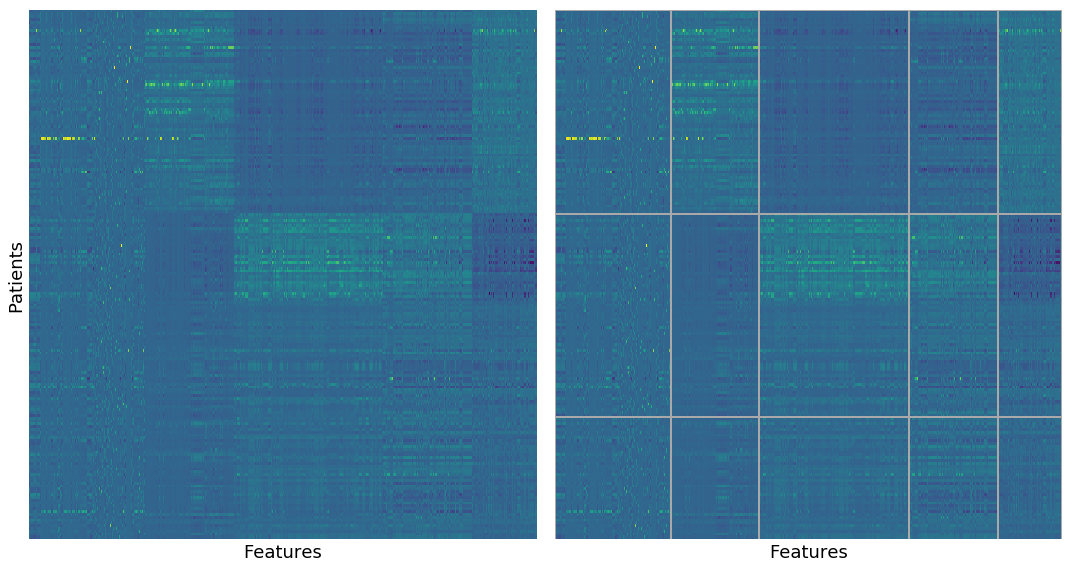

In [21]:
# Train model with best config.
rs_bic_model = SpectralBiclustering(
    random_state=SEED, svd_method='arpack'
)
rs_bic_model.set_params(**best_rs_config)
rs_bic_model.fit(X_rs_std)
rs_bic_row_sorted = X_rs_std[np.argsort(rs_bic_model.row_labels_), :]
rs_bic_fit_data = rs_bic_row_sorted[:, np.argsort(rs_bic_model.column_labels_)]


fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 8),
    sharey=True
)
sns.heatmap(
    rs_bic_fit_data, 
    ax=axes[0], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(rs_bic_fit_data), 
    vmax=np.max(rs_bic_fit_data),
    cbar=False
)
sns.heatmap(
    rs_bic_fit_data, 
    ax=axes[1], 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(rs_bic_fit_data), 
    vmax=np.max(rs_bic_fit_data),
    cbar=False
)
coords = checker_coords(rs_bic_model, best_rs_config['n_clusters'])
for num in coords.index:
    axes[1].plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='darkgray'#'orangered' #darkred
)
axes[0].set_ylabel('Patients', fontsize=18)
for axis in axes.ravel():
    axis.set_xlabel('Features', fontsize=18)
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.tight_layout()

plt.savefig(
    './bicmap_removed_slices_images.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [22]:
# Collect row cluster info.
rs_row_idx = []
rs_pfs_outcome, rs_not_pfs_outcome = [], []
for bic_row_idx in np.unique(rs_bic_model.row_labels_):
    # Store cluster index and ID samples belonging to current cluster.
    rs_row_idx.append(bic_row_idx)
    row_cluster_samples = np.where(rs_bic_model.row_labels_ == bic_row_idx)

    # Store fractions of each outcome for current cluster.
    rs_pfs_outcome.append(sum(y_rs[row_cluster_samples] == 0) / np.size(y_rs))
    rs_not_pfs_outcome.append(sum(y_rs[row_cluster_samples] == 1) / np.size(y_rs))
    
rs_sorted_cluster_idx = np.concatenate((rs_row_idx, rs_row_idx))
rs_comb_results = np.concatenate((rs_pfs_outcome, rs_not_pfs_outcome))

rs_results_id =  np.concatenate((
    ['Progression-free Survival'] * len(rs_pfs_outcome), ['Other Event'] * len(rs_not_pfs_outcome)
))
df_rs_row_clusters = pd.DataFrame(
    {'comb_results': rs_comb_results, 'results_id': rs_results_id},
    index=rs_sorted_cluster_idx,
)

# Collect column cluster info.
rs_column_clusters = {}
for bic_col_idx in np.unique(rs_bic_model.column_labels_):    
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(rs_bic_model.column_labels_ == bic_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples, X_rs)
    rs_column_clusters[bic_col_idx] = {key: val_a + val_b for (key, val_a), (_, val_b) 
                                       in zip(pet_output.items(), ct_output.items())}
    
df_rs_column_clusters = pd.DataFrame(rs_column_clusters).T

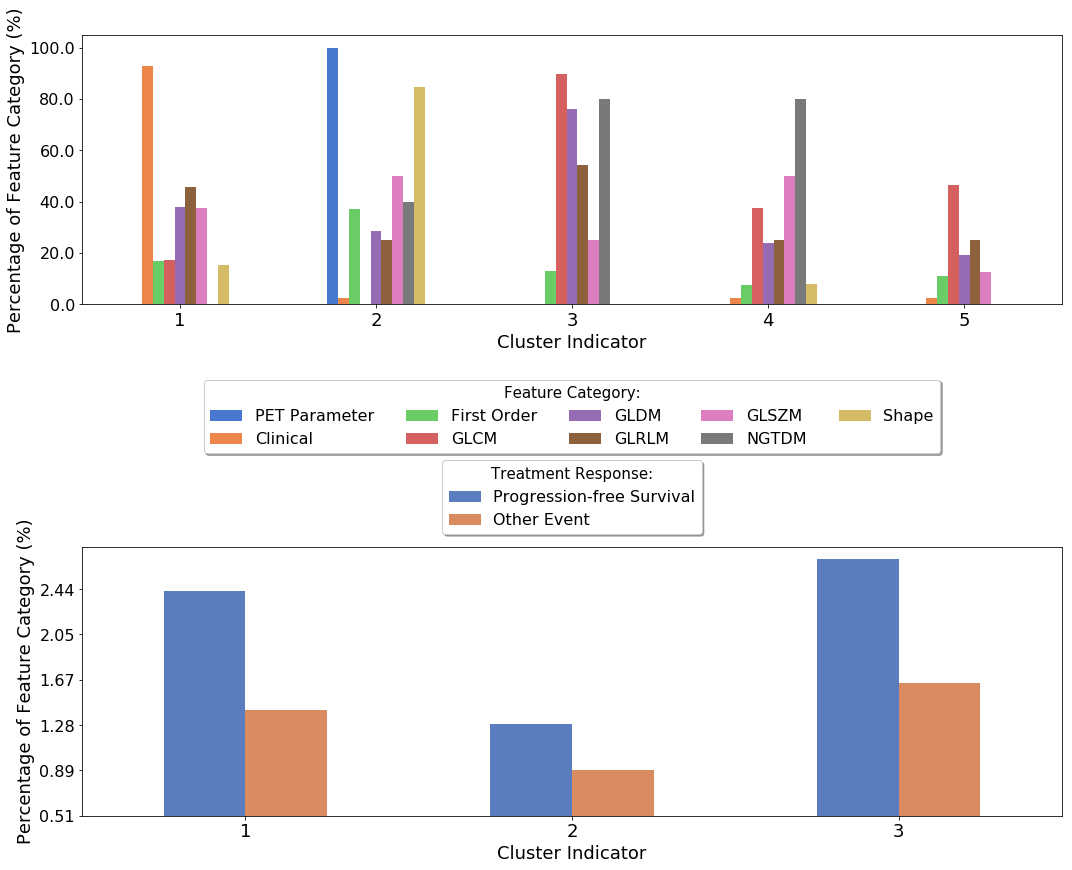

In [23]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 12))
df_rs_column_clusters.plot(
    kind='bar', 
    ax=axes[0], 
    colormap=ListedColormap(sns.color_palette('muted', n_colors=9))
)
sns.barplot(
    x=rs_sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_rs_row_clusters,
    palette='muted',
    ax=axes[1]
)
for num, patch in enumerate(axes[1].patches):
    if num in np.arange(len(axes[1].patches) * 0.5, dtype=int):
        patch.set_width(0.25)
        patch.set_x(patch.get_x() + 0.15)
    else:
        patch.set_width(0.25)
        
axes[0].set_xticklabels(np.arange(8) + 1, fontsize=18, rotation=0)
axes[1].set_xticklabels(np.arange(20) + 1, fontsize=18, rotation=0)

axes[0].set_yticklabels(
    np.linspace(
        np.min(df_rs_column_clusters.values) * 100, 
        np.max(df_rs_column_clusters.values) * 100, 
        len(df_rs_column_clusters.index) + 1
    ), 
    fontsize=16, rotation=0
)
axes[1].set_yticklabels(
    np.round(np.linspace(
        np.min(df_rs_row_clusters.loc[:, 'comb_results'].values) * 10, 
        np.max(df_rs_row_clusters.loc[:, 'comb_results'].values) * 10, 
        len(df_rs_row_clusters.index) + 1
    ), 2), 
    fontsize=16, rotation=0
)
axes[0].set_xlabel('Cluster Indicator', fontsize=18)
axes[1].set_xlabel('Cluster Indicator', fontsize=18)

axes[0].set_ylabel('Percentage of Feature Category (%)', fontsize=18)
axes[1].set_ylabel('Percentage of Feature Category (%)', fontsize=18)

axes[0].legend(
    format_feature_labels(df_orig_column_clusters.columns),
    title='Feature Category:', title_fontsize=15,
    loc='upper center', bbox_to_anchor=(0.5, -0.25), 
    ncol=5, fontsize=16, shadow=True, fancybox=True
)
axes[1].legend(
    title='Treatment Response:', title_fontsize=15,
    loc='upper center', bbox_to_anchor=(0.5, 1.35), 
    ncol=1, fontsize=16, shadow=True, fancybox=True
)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)

plt.savefig(
    './biclusters_removed_slices.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)